In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./../data_formatted/training_dataset.csv",low_memory=False)
df.match_date = df.match_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [2]:
df = df.dropna()
df.shape

df = df[(df.player1_plays > 6) & (df.player2_plays>6)]
df.shape

(36972, 36)

In [3]:
from sklearn.model_selection import train_test_split

X = df[["player1_name", "player1_age", "player1_atprank", "player1_plays", "player1_wins", "player1_losses", "player1_elo", "player1_mean_serve_rating", "player1_mean_atp_adversary", "player1_height", "player1_weight", "player1_oddsB365",
        "player2_name", "player2_age", "player2_atprank", "player2_plays", "player2_wins", "player2_losses", "player2_elo", "player2_mean_serve_rating", "player2_mean_atp_adversary", "player2_height", "player2_weight", "player2_oddsB365",
        "match_date"]]
y = df.winner_player1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)# shuffle=False)

In [4]:
from sklearn import preprocessing

col_to_drop = ["player1_name", "player2_name", "match_date"]
X_train_filtered = X_train.drop(col_to_drop,axis=1)
X_test_filtered = X_test.drop(col_to_drop,axis=1)

In [5]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3,max_depth=1, random_state=0)
model = model.fit(X_train_filtered, y_train)

cross_val_score(model, X_test, y_test, cv=10)

#y_predict = model.predict(X_test_filtered)

#accuracy_score(y_predict, y_test)

In [7]:
# ROI return of investment on all games

print("We bet 1€ on all test matches")
df_roi = X_test.copy()
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in df_roi.iterrows():
    if row.y_predict == row.y_test :
        if row.y_predict == 0 :
            money_won += row.player2_oddsB365
        else:
            money_won += row.player1_oddsB365

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")

We bet 1€ on all test matches
money spent: 7395 €
money won: 6986.71 €
TOTAL: -408.28999999999996 €


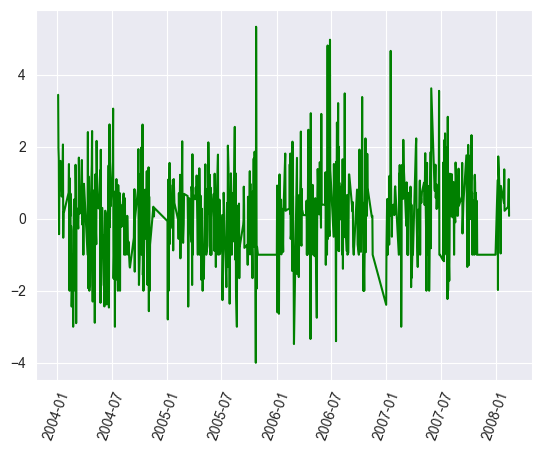

In [20]:
# on all games 
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.player2_oddsB365
        else:
            money_won += row.player1_oddsB365

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [33]:
#only games where predict proba is > 0.8

y_predict_proba = model.predict_proba(X_test_filtered)


print("We bet 1€ on all test matches where proba score is > 0.9")
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

df_roi= df_roi.loc[df_roi["y_predict_proba"]>0.9]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.player2_oddsB365
    else:
        money_won += row.player1_oddsB365

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

We bet 1€ on all test matches where proba score is > 0.9
money spent: 338 €
money won: 333.07 €
TOTAL: -4.93 €
ROI: 98.54 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_29852\1447167343.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


In [24]:
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"] = y_test

df_roi["proba_bookmaker"] = 1/df_roi.player2_oddsB365
df_roi[["player1_name","player2_name","y_predict", "y_test","y_predict_proba","proba_bookmaker"]]

,player1_name,player2_name,y_predict,y_test,y_predict_proba,proba_bookmaker
8647,Lleyton Hewitt,James Blake,1,1,0.099752,0.133333
6179,Juan Monaco,Luis Horna,0,0,0.500809,0.421941
15904,James Blake,Jarkko Nieminen,1,1,0.285592,0.294118
6057,Cyril Saulnier,Robby Ginepri,0,1,0.510256,0.619195
10266,Mikhail Youzhny,Ivo Minar,1,1,0.356646,0.476190
...,...,...,...,...,...,...
14361,Juan Carlos Ferrero,Guillermo Canas,0,0,0.771028,0.719424
12716,Stan Wawrinka,Lukas Dlouhy,1,1,0.485084,0.348432
8893,Kenneth Carlsen,Andy Roddick,0,1,0.885698,0.943396
14237,Jan Hernych,Tim Henman,0,1,0.735236,0.735294


In [26]:
df_roi = df_roi.loc[df_roi.y_predict_proba > df_roi.proba_bookmaker]

money_invested=df_roi.shape[0]
money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.player2_oddsB365
    else:
        money_won += row.player1_oddsB365

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")

money spent: 426 €
money won: 487.26 €
TOTAL: 61.26 €
ROI: 114.38 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_29852\4173674621.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


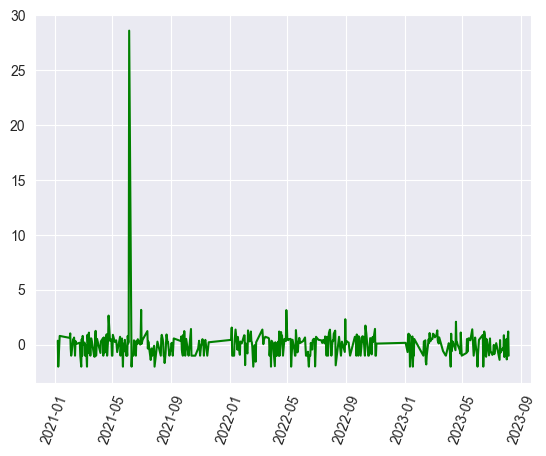

In [39]:
# on proba score > 0.9 (roi filtered from previous cell)
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [55]:
df_roi = df_roi.sort_values(by='match_odd_player1')
df_roi.head()

,player1_name,player1_atprank,player1_games,player1_wins,player1_losses,player1_indoor_wins,player1_indoor_losses,player1_outdoor_wins,player1_outdoor_losses,player2_name,...,player2_indoor_losses,player2_outdoor_wins,player2_outdoor_losses,tournament_court,match_date,match_odd_player1,match_odd_player2,y_predict_proba,y_predict,y_test
1524,Djokovic N.,2,1207,1012,195,146,42,866,153,Garin C.,...,13,88,74,Outdoor,2021-07-05,1.01,21.0,0.017127,1,1
3709,Nadal R.,2,1223,1017,206,76,40,941,166,Thompson J.,...,10,86,115,Outdoor,2022-05-23,1.01,23.0,0.015796,1,1
3783,Djokovic N.,2,1207,1012,195,146,42,866,153,Bedene A.,...,23,113,137,Outdoor,2022-05-27,1.01,21.0,0.011709,1,1
1139,Djokovic N.,2,1207,1012,195,146,42,866,153,Molcan A.,...,6,44,35,Outdoor,2021-05-29,1.02,19.0,0.031417,1,1
1141,Tsitsipas S.,5,390,264,126,49,32,215,94,Chardy J.,...,48,245,254,Outdoor,2021-05-30,1.02,17.0,0.060927,1,1


In [41]:
#Ici on veut conserver uniquement les jouerus qui ont fait déja au moins 6 matchs en pro
df_roi= df_roi.loc[(df_roi["player1_games"]>6) & (df_roi["player2_games"]>6)]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

money spent: 655 €
money won: 649.93 €
TOTAL: -5.07 €
ROI: 99.23 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_12468\29534856.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


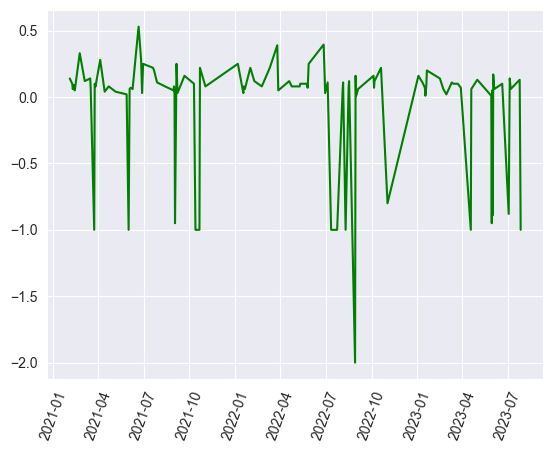

In [11]:
# on proba score > 0.9 (roi filtered from previous cell)
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)